In [1]:
# https://github.com/ismailuddin/gradcam-tensorflow-2/blob/master/notebooks/GradCam.ipynb

In [2]:
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf

import matplotlib.pyplot as plt

import numpy as np

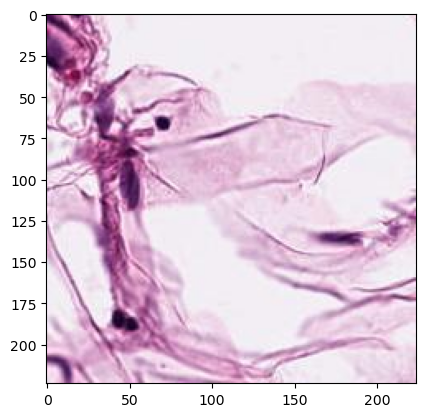

In [45]:
image = np.array(load_img("../../CRC-VAL-HE-7K/ADI/ADI-TCGA-ADTVLITV.tif.jpg.jpg", target_size=(224, 224, 3)))
plt.imshow(image)

In [46]:
model = load_model('../../models/resnet_scratch_50_12.h5')

In [47]:
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad

In [48]:
class GuidedBackprop:
    def __init__(self, model, layer_name: str):
        self.model = model
        self.layer_name = layer_name
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):
        gb_model = tf.keras.Model(
            self.model.inputs, self.model.get_layer(self.layer_name).output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray):
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
        grads = tape.gradient(outputs, inputs)[0]
        return grads

In [49]:
gb = GuidedBackprop(model, "conv5_block3_out")


In [50]:
saliency_map = gb.guided_backprop(image[np.newaxis, ...]).numpy()

In [51]:
saliency_map -= saliency_map.mean()
saliency_map /= saliency_map.std() + tf.keras.backend.epsilon()
saliency_map *= 0.25
saliency_map += 0.5
saliency_map = np.clip(saliency_map, 0, 1)
saliency_map *= (2 ** 8) - 1
saliency_map = saliency_map.astype(np.uint8)

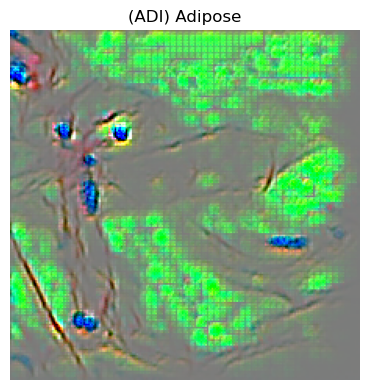

In [52]:
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(saliency_map)
ax.set_title('(ADI) Adipose', fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.show()